# Introduction to Q-learning

# Motivation: Digital Quantum Simulation

Goal: replicate the dynamics of a Hamiltonian using a quantum computer


$Q(s, a) = ...$

## Reinforcement learning 

- "agent" learning while interacting with an environment that return numerical rewards
- goal: take actions that maximize the reward
- algorithms: structured around estimating value functions

## Overview
- Introduction: the multi-armed bandit (exploration vs exploitation)
- Markov decision process
- Dynamical programming
- Monte-Carlo methods
- TD methods (with interactive Q-learning algorithm) 

# Multi-armed bandit

<img src="tako.png" width="600"/>

## Reinforcement learning vs other types of learning:
- uses  training  information  that evaluates the  actions  taken  rather  than instructs by  giving  correct actions.

## k-armed bandit:
- choose between k options (actions)
- receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected 
- goal: maximize the expected total reward over many time steps.

## Action-value method
The value of an action is defined as $q_*(a) = \mathbb{E}(R_t | A_t = a) $

Simplest estimation of $q_*$ is $Q_t = \frac{\sum_{i=1}^{t-1} R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$ : average of the rewards received for $a$.

## Exploitation vs Exploration
At a given time, the simplest action selection rule (also called a _policy_) is
$$A_t = {\underset{a}{\operatorname{argmax}}} \, Q_t(a)$$

This is the _greedy_ policy. It exploits current knowledge.
Dilemma: apparently inferior actions might actually be better.

Simple alternative: ___$\varepsilon$-greedy___ action selection
$$ A_t = \left\{ \begin{eqnarray} &{\rm random} \qquad &{\rm with \, \, prob} \, \, \varepsilon \\ &{\underset{a}{\operatorname{argmax}}} \, Q_t(a) \qquad &{\rm else} \end{eqnarray} \right.$$

This policy is central to a lot of reinforcement learning algorithms.


### 10-armed bandit testbed
For each arm $q_*(a)$ (the mean reward) is chosen randomly according to $\mathcal{N}(0, 1)$, and the rewards follow $\mathcal{N}(q_*(a), 1)$.

<IPython.core.display.Javascript object>


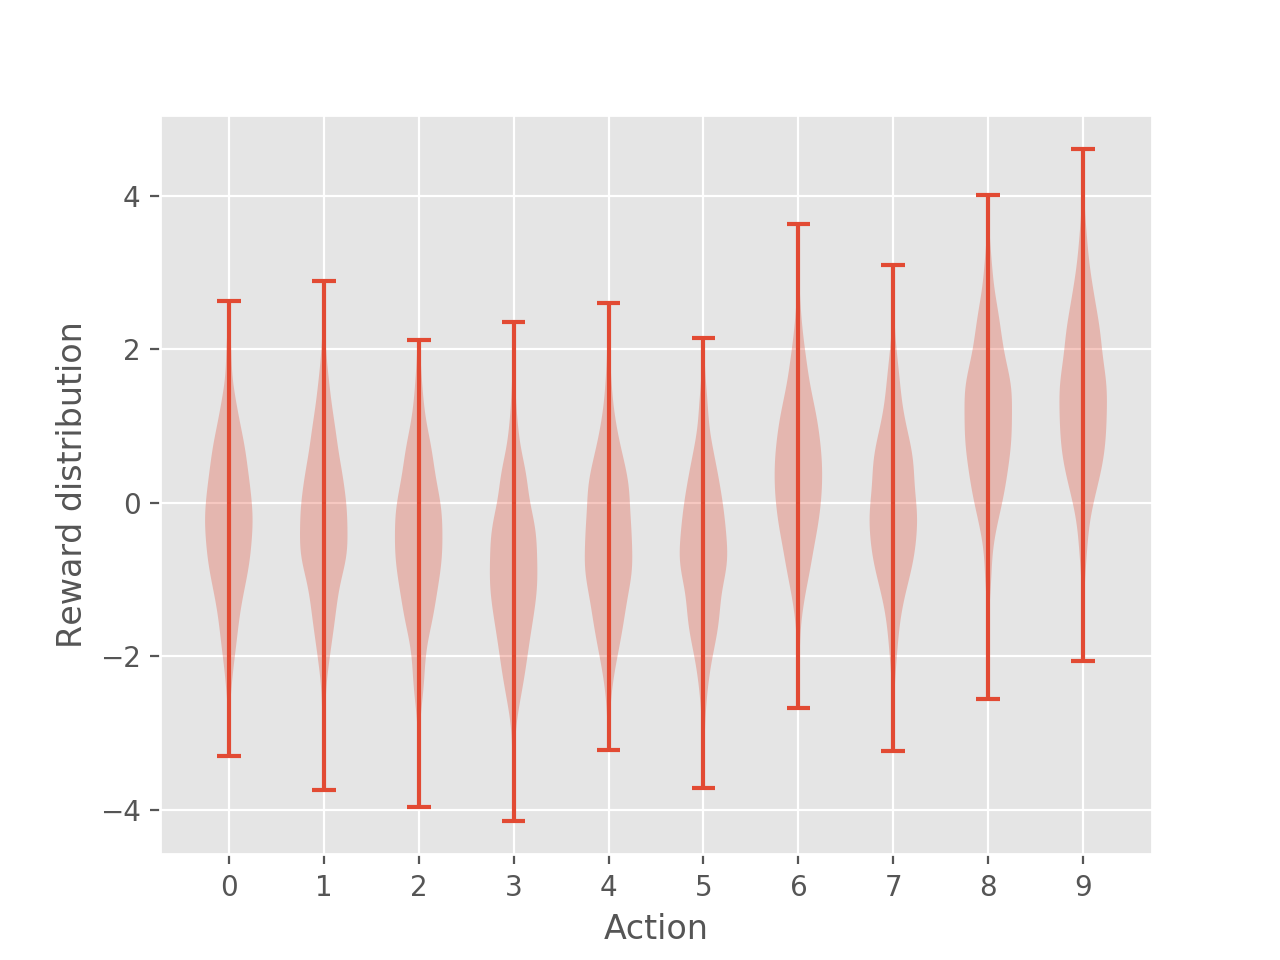

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from tqdm import trange
from time import sleep

plt.violinplot(dataset=np.random.randn(1000, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.xticks(range(1, 11), range(10))
plt.show()

In [2]:
class Bandit():
    
    def __init__(self, k, epsilon=0.0, seed=0):
        self.k = k
        self.epsilon = epsilon
        np.random.seed(seed)
        self.reset()
    
    def reset(self):
        self.time = 0
        # mean reward for each action (each arm)
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true)
        # estimation for each action
        self.q_estimation = np.zeros(self.k)
        # count for each action
        self.action_count = np.zeros(self.k, dtype=int)
        
    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(self.k))
        else:
            q_best = np.max(self.q_estimation)
            return np.random.choice(np.nonzero(self.q_estimation == q_best)[0])
        
    def step(self, action):
        self.time +=1
        # generate reward
        reward = np.random.randn() + self.q_true[action]
        self.action_count[action] += 1
        
        # incremental update (step size = 1/action_count)
        self.q_estimation[action] += (reward - self.q_estimation[action])/self.action_count[action]
        
        return reward

Simulating 4 10-arm bandits up to t=1000, 2000 times each.


100%|██████████| 2000/2000 [00:23<00:00, 84.44it/s]


<IPython.core.display.Javascript object>


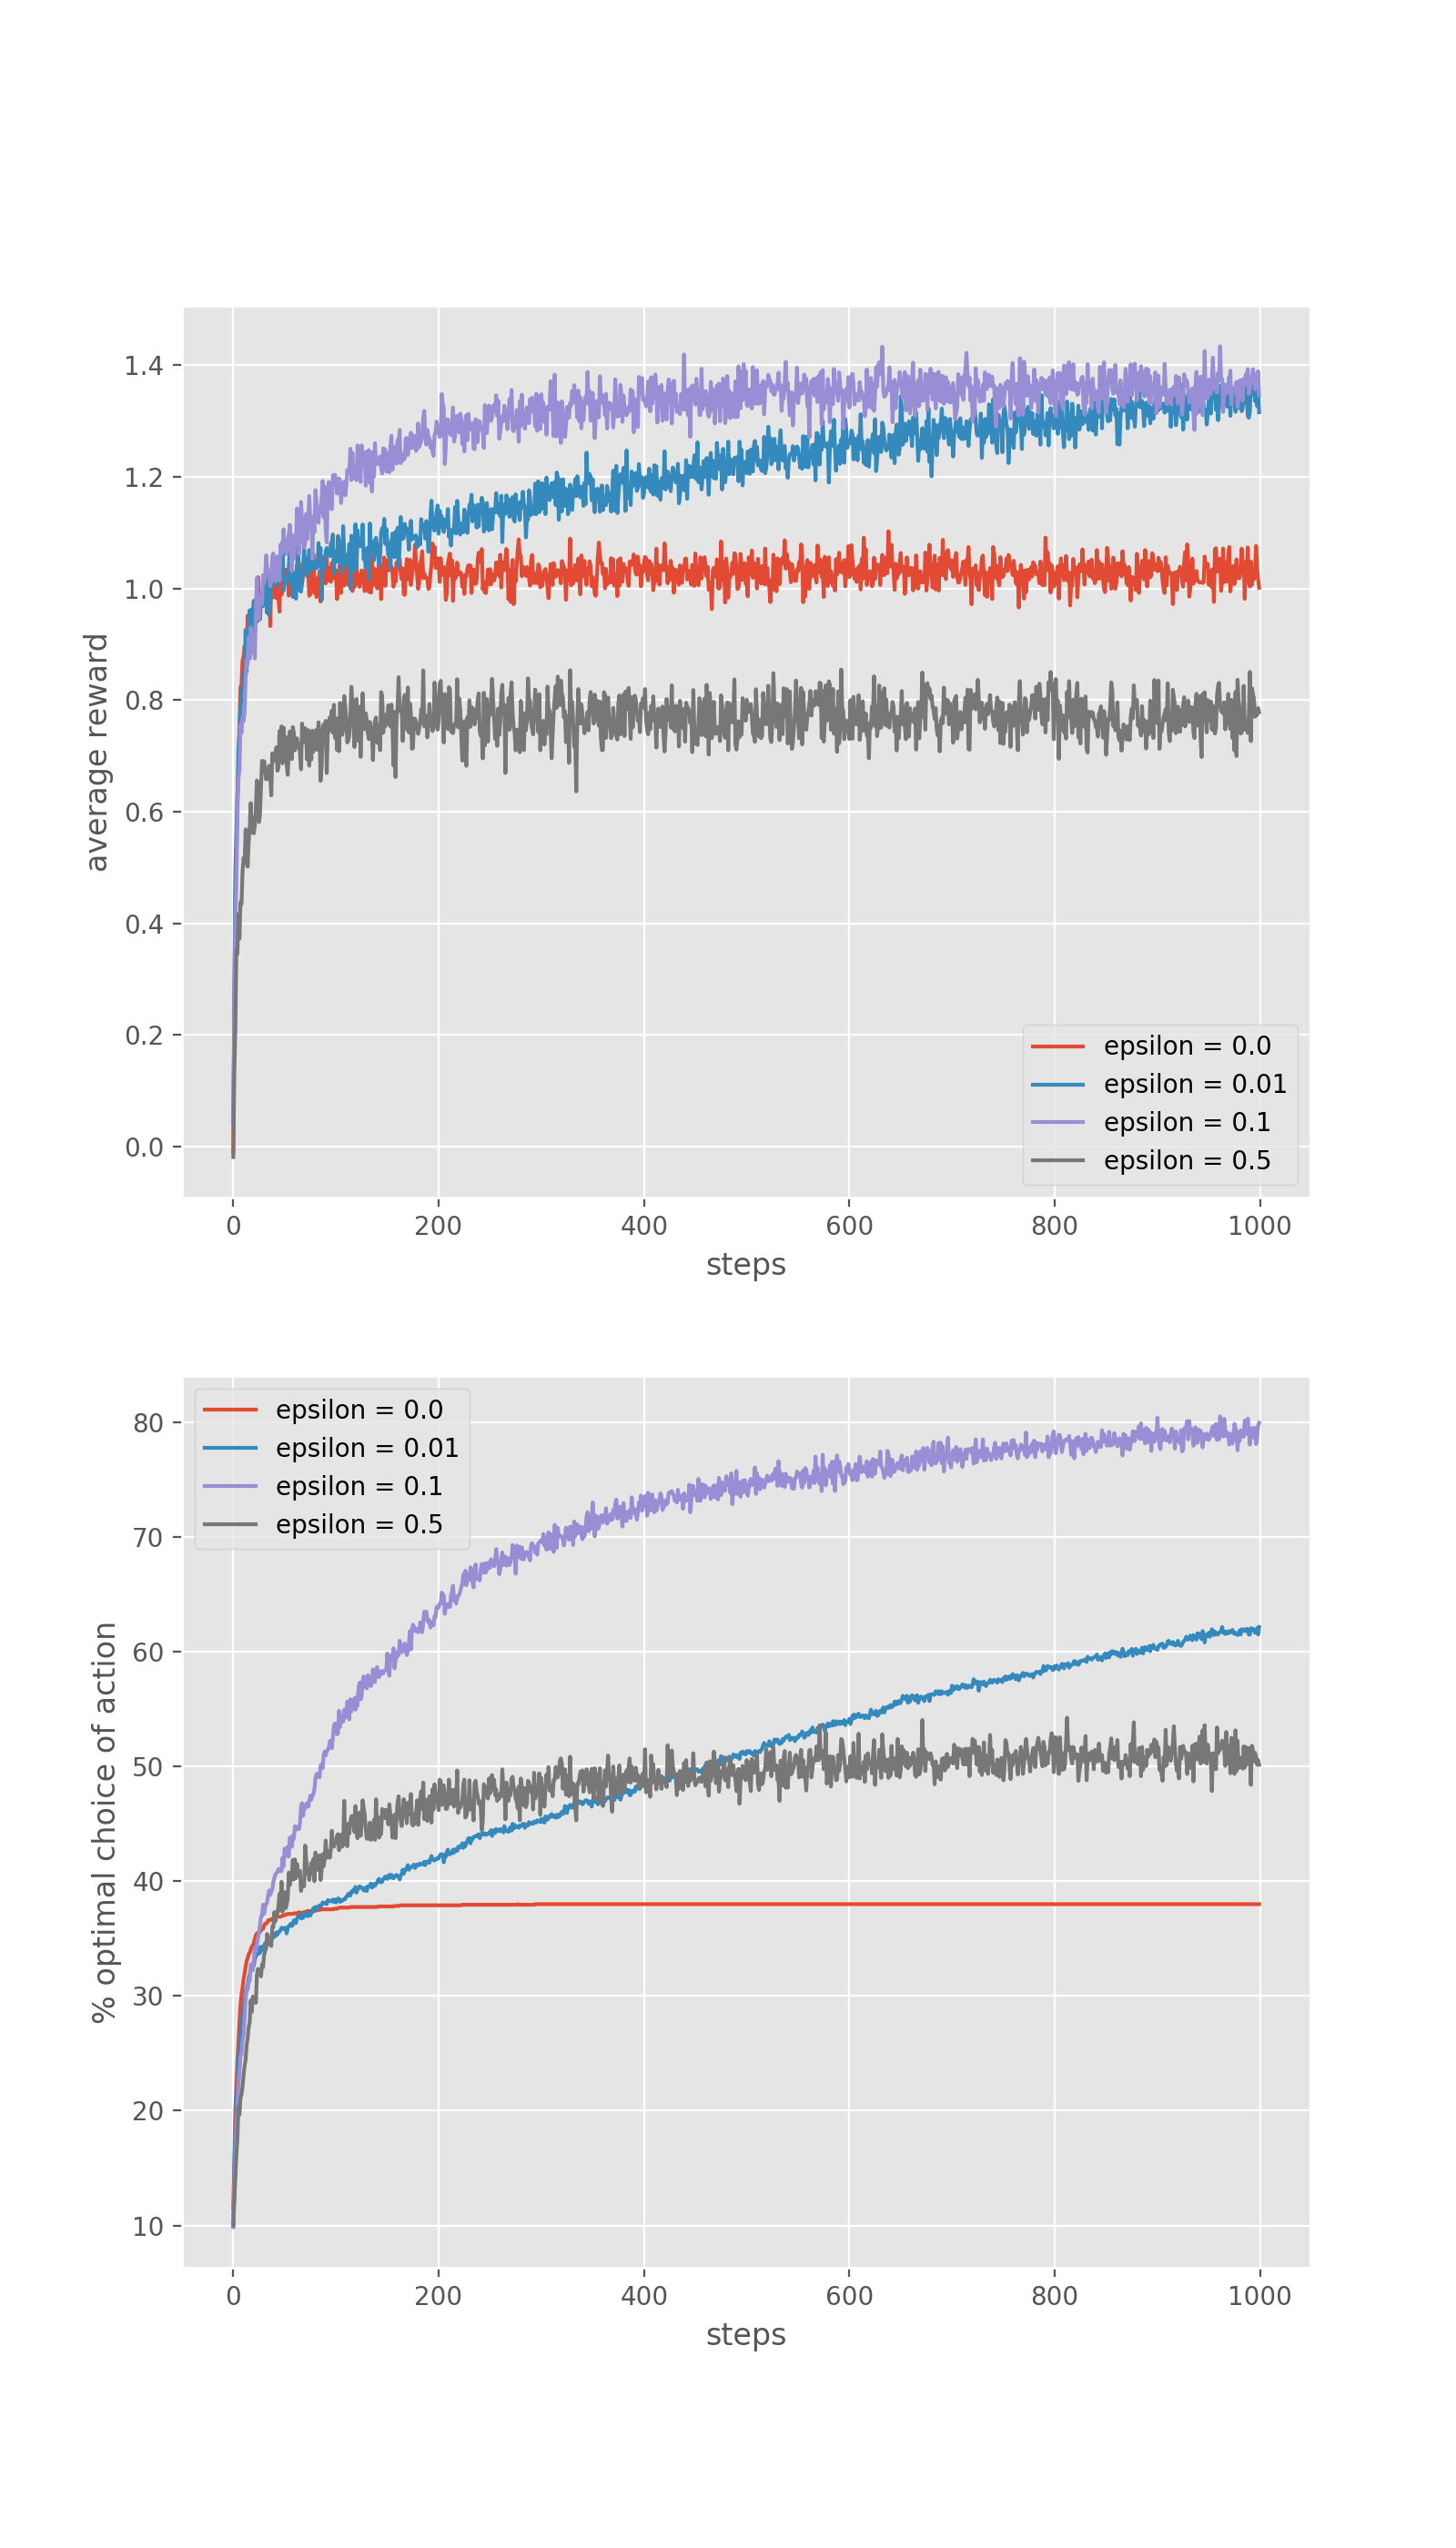

In [6]:
def simulate(n_runs, max_time, bandits):
    """n_runs (with different q_*) of all bandits up to t=max_time"""
    
    print(f"Simulating {len(bandits)} {bandits[0].k}-arm bandits up to t={max_time}, {n_runs} times each.")
    sleep(0.5)
    # track two metrics
    rewards = np.zeros((len(bandits), n_runs, max_time))
    optimal_choice_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for run in trange(n_runs):
            bandit.reset()
            for time in range(max_time):
                action = bandit.choose_action()
                reward = bandit.step(action)
                rewards[i, run, time] = reward
                if action == bandit.best_action:
                    optimal_choice_counts[i, run, time] = 1
    mean_optimal_choice_counts = optimal_choice_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_optimal_choice_counts, mean_rewards


def bandit_figure(n_runs, max_time):
    epsilons = [0., 0.01, 0.1, 0.5]
    bandits = [Bandit(k=10, epsilon=eps) for eps in epsilons]
    optimal_choice_counts, rewards = simulate(n_runs, max_time, bandits)
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 14))
    
    for eps, rewards, counts in zip(epsilons, rewards, optimal_choice_counts):
        ax[0].plot(rewards, label=f'epsilon = {eps}')
        ax[1].plot(100*counts, label=f'epsilon = {eps}')
    ax[0].set_xlabel('steps')
    ax[0].set_ylabel('average reward')
    ax[0].legend()
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('% optimal choice of action')
    ax[1].legend()
    
bandit_figure(n_runs=2000, max_time=1000)

# Markov Decision Processes

- __Sequential__ decision making: state of the environment change with action
- Actions influence not only the immediate rewards, but also the subsequent states $\rightarrow$ delayed rewards

## The Agent-Environment Interface

- At each time step $t$: agent receives information about the state $S_t \in \mathcal{S}$, chooses an action $A_t \in \mathcal{A}$. One time step later, the agent receives a reward $R_{t+1} \in \mathcal{R}$ and finds itself in a new state $S_{t+1}$.

<img src="agent-environment.png" width="600"/>

- MDP + agent give rise to trajectories $$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 ... $$

# The end